# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

#Preparazione dei dati

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3) #50k immagini,32*32,3 canali,faremo poi una split qua per avere 5k per validation set
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1) #50k immagini con una label in [0,10]
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

cifar10_y_train_flattened = cifar10_y_train.flatten()

cifar10_x_train, val_x, cifar10_y_train, val_y = train_test_split(cifar10_x_train, cifar10_y_train, test_size=0.1, random_state=42,stratify=cifar10_y_train_flattened)
#stratify cosi i dati in validazione sono "in scala"

# Check shapes
print(f"Dim dati in training {cifar10_x_train.shape}, {cifar10_y_train.shape}")
print(f"Dim dati in test {cifar10_x_test.shape}, {cifar10_y_test.shape}")
print(f"Dim dati di validazione: {val_x.shape}, {val_y.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Dim dati in training (45000, 32, 32, 3), (45000, 1)
Dim dati in test (10000, 32, 32, 3), (10000, 1)
Dim dati di validazione: (5000, 32, 32, 3), (5000, 1)


Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [ ]:
#input per modello sara = x_train_1+x_train2
#ground truth = y_train1,y_train2

cond_1 = cifar10_y_train[:,0] < 5 #cond1 array di bool,=1 solo se y appartiene a [0,4]-->(airplane, automobile, bird, cat, deer)
cifar10_x_train_1 = cifar10_x_train[cond_1]  #x_train_1=x_train[1,0,1,1,0,....,1]-->x_train_1 prende i-esima in xtrain quando cond1[i]=1 e qundi ytrain in 0,4
cifar10_y_train_1 = cifar10_y_train[cond_1]  #stessa cosa per le label,riprendo quelle in classe 0,4

cond_2 = cifar10_y_train[:,0] >= 5 #esatto procedimento per l'imm x_train2
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5 #e per i dati in test
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

cond_1_test = val_y[:,0] < 5 #e per i dati in test
val_x_1 = val_x[cond_1_test]
val_y_1 = val_y[cond_1_test]

cond_2_test = val_y[:,0] >= 5
val_x_2 = val_x[cond_2_test]
val_y_2 = val_y[cond_2_test]

#ora ho x_train1,x_train2 con label giuste, in modo da avere un input che sia imm_classe0-4+imm_classe5-9
#poi ho ytrain_1,y_train2 in modo da poter distinguere label a seconda di prima o seconda immagine
#per i x,y test stessa cosa ma per la valutazione del modello

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize): #restituisci #batchsize immagini, del tipo X1[rand]+X2[rand], e corripondenti label Y1[rand],Y2[rand]
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data

Instanziamo un generatore su Cifar10 con batchsize=1, e testiamone il comportamento.

In [ ]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,3)
#datagen contiene ora 3 record,ognuno composto da x(ottenuta da X1rand1+X2rand2)
#e y(yrand1,yrand2) ={[x,y],[x,y],[x,y]} x una immagine,y=[yrand1,yrand2] corrispondenti classi

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: deer, second = frog


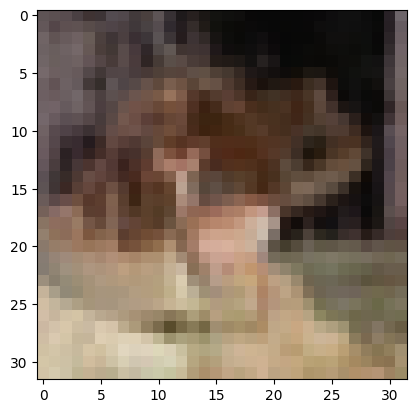

In [ ]:
x, y = next(datagen) #semplicemente riprendi il prox elem di datagen

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.imshow(x[0])


# Valutazione

Dfiniamo innanzi tutto il generatore di testing.

In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)#altri 10k record per il testing
eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


In [8]:
#questa funzione è il modo piu semplice per passare da [x,[y1,y2]] a (x,(y1,y1)),che è il formato necessario
def converti_out_generatore(generator):
    for x_data, y_data in generator:
        yield x_data, tuple(y_data)  #ora ho una tupla da poter passare a .fit

datagen = ImageDataGenerator(  #qui definiamo le trasfromaioni che verrano usate per generare "nuove" immagini
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

def augment_data(X, Y, datagen, dimX, batch_size=8):  #impostiamo un batchsize basso per poterlo eseguire senza riempire la memoria
    import numpy as np
    augmented_X = []
    augmented_Y = []
    total_needed =  dimX
    flow = datagen.flow(X, Y, batch_size=8, shuffle=True)

    while len(augmented_X) < total_needed:
        batch_x, batch_y = next(flow) #nuova immagine x distorta con etichetta originale
        augmented_X.append(batch_x)
        augmented_Y.append(batch_y)

    augmented_X = np.concatenate(augmented_X, axis=0)[:total_needed]
    augmented_Y = np.concatenate(augmented_Y, axis=0)[:total_needed]

    return augmented_X, augmented_Y


#PRIMA generiamo nuovi dati
dim = 25000
X1_aug, Y1_aug = augment_data(cifar10_x_train_1, cifar10_y_train_1, datagen, dimX=dim, batch_size=8)
X2_aug, Y2_aug = augment_data(cifar10_x_train_2, cifar10_y_train_2, datagen, dimX=dim, batch_size=8)

cifar10_x_train_1_final = np.concatenate([cifar10_x_train_1, X1_aug], axis=0) #originale+generato
cifar10_y_train_1_final = np.concatenate([cifar10_y_train_1, Y1_aug], axis=0)

cifar10_x_train_2_final = np.concatenate([cifar10_x_train_2, X2_aug], axis=0)
cifar10_y_train_2_final = np.concatenate([cifar10_y_train_2, Y2_aug], axis=0)



Testiamo con una nodello che produce predizioni random. Voi dovrete sostituire questo modello con il vostro modello predittivo.

In [9]:

def def_model():  #definiamo la struttura del modello,layers,kernel,e iperparametri vari
    #questa funzione è il modo piu semplice per passare da [x,[y1,y2]] a (x,(y1,y1)),che è il formato necessario
    def converti_out_generatore(generator):
        for x_data, y_data in generator:
            yield x_data, tuple(y_data)  #ora ho una tupla da poter passare a .fit

    #cnn
    #input layer
    input_layer = Input(shape=(32,32,3))
    #layer 1
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # shape => (16, 16, 32)

    #layer 2
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # shape => (8, 8, 64)

    #layer 3
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)    #ho provato vari rate,per trovare il compromesso tra % minima di overfitting e una rete che impara troppo lentamente,inoltre il rate è piu alto nel layer con piu parametri
    x = Dense(64, activation='relu')(x)  #perchè è più propenso a fare overfitting
    x = Dropout(0.1)(x)

    y1_output = Dense(5, activation='softmax', name='y1_output')(x) #softmax per restituire un array di probabilitò per ogni classe
    y2_output = Dense(5, activation='softmax', name='y2_output')(x)

    model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

    from keras.optimizers.schedules import ExponentialDecay

    # Definizione dello scheduler per il learning rate
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,  # Learning rate iniziale
        decay_steps=10000,           # Passi per il decadimento
        decay_rate=0.9,              # Fattore di decadimento
        staircase=True
    )

    adam_optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=adam_optimizer,
        loss={'y1_output': 'categorical_crossentropy', 'y2_output': 'categorical_crossentropy'},
        metrics={'y1_output': CategoricalAccuracy(), 'y2_output': CategoricalAccuracy()}
    )

    return model

def create_model(batch_size,epochs):  #separiamo il metodo per il training del modello una volta definito per una struttura migliore
    model = def_model()
    model.summary()
    steps_per_epoch = (45000+dim)//batch_size  #dove dim è il numero di dati generati durante data augmentation

    trainingData = converti_out_generatore(datagenerator(  #istanziamo un generatore,convertiamo in ruple
    cifar10_x_train_1_final,  #ovviamente in training lavoriamo con il dataset augmented
    cifar10_x_train_2_final,
    cifar10_y_train_1_final,
    cifar10_y_train_2_final,
    batchsize=batch_size
    ))

    evaluationData = converti_out_generatore(datagenerator(val_x_1, val_x_2, val_y_1, val_y_2, batch_size))  #dati per monitorare il training e cambiare ipermaretri come necessario
    #ho creato un dataset che fosse diverso da x_test,y_test per evitare di fare tuning sulla performance su di essi,equivarrebbe a overfittare "manualmente"

    history=model.fit(
        trainingData,
        shuffle=True,
        validation_data=evaluationData,
        validation_steps=150,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
    )

    return model,history  #ritorno anche history per fare un grafico delle loss/accuracy per monitorare il training


Modifica funzione di valutazione,stessa logica con qualche differenza implementativa

def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
nell codice originale il modello resitutisce coppie di 2 valori,ognugno la classe predetta
nel confronto quindi verico se la classe predetta è uguale all indice con valore max (valore 1) dell vettore ground truth
il mio modello restituisce però un array di probabilità,quindi devo modificare qualcosa

  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [10]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  answers = model.predict(eval_samples_x) #produce array di risposte del tipo [y1,y2] dove y1 è la distribuzione di probabilità per label x1,y2  // per label di x2

  y1_pred = answers[0]  #dividiamo per rendere tutto più leggibile
  y2_pred = answers[1]

  #se y1_pred[i]==evalSamples[i],dove i è l'indice con a[i] valore max,confronto label reale (y1_pred[i]=1) e la classe piu probabile,
  #se l'indice corrisponde allora il modello ha assegnato probabilità max al valore piu alto
  #ex argmax([1. 0. 0. 0. 0.])==argmax[0.6,0.1,0.1,0.1,0.1]--->0==0--->guess corretta
  correct_guesses_1 = np.argmax(y1_pred, axis=1) == np.argmax(eval_samples_y[0], axis=1) #verifichiamo quali guess sono corretti
  correct_guesses_2 = np.argmax(y2_pred, axis=1) == np.argmax(eval_samples_y[1], axis=1)

  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2   #media X1indovinate+X2indovinate

modelloProva,history=create_model(128,80)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 128)      │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 128)            │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 506,186 (1.93 MB)

 Trainable params: 506,186 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 3.0963 - y1_output_categorical_accuracy: 0.2622 - y1_output_loss: 1.5540 - y2_output_categorical_accuracy: 0.2811 - y2_output_loss: 1.5424 - val_loss: 2.7728 - val_y1_output_categorical_accuracy: 0.3935 - val_y1_output_loss: 1.4026 - val_y2_output_categorical_accuracy: 0.4240 - val_y2_output_loss: 1.3702
Epoch 2/80
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.7630 - y1_output_categorical_accuracy: 0.3942 - y1_output_loss: 1.3994 - y2_output_categorical_accuracy: 0.4247 - y2_output_loss: 1.3635 - val_loss: 2.5739 - val_y1_output_categorical_accuracy: 0.4267 - val_y1_output_loss: 1.3254 - val_y2_output_categorical_accuracy: 0.4818 - val_y2_output_loss: 1.2485
Epoch 3/80
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.6054 - y1_output_categorical_accuracy: 0.4272 - y1_output_loss: 1.3417 - y2_output_categorical_accuracy: 0.4814 - y2_output_loss: 1.2636 - val_loss: 2.4025 - val_y1_output_categorical_accuracy: 0.4672

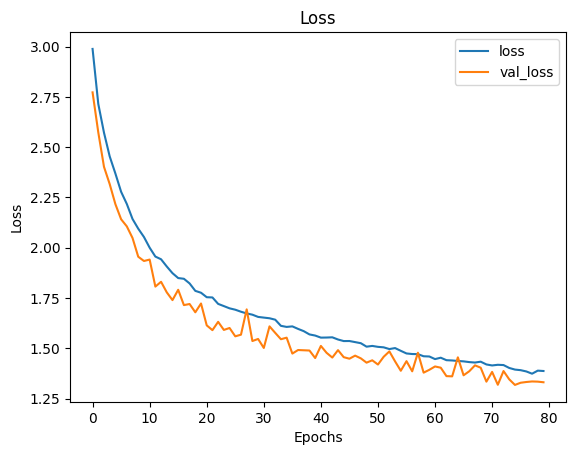

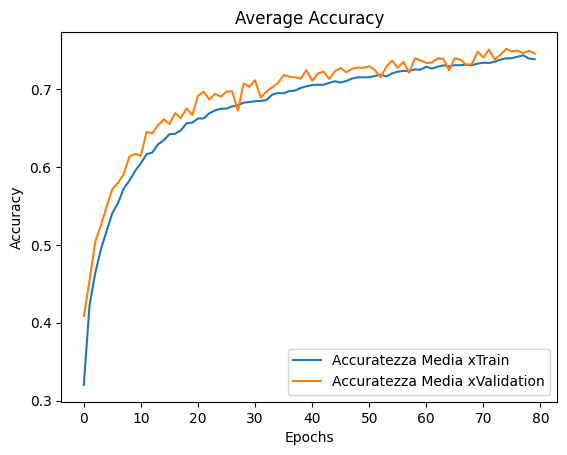

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert history.history to a pandas DataFrame
df = pd.DataFrame(history.history)

#la metrica è l'accuratezza media sulle 2 label
df['Accuratezza Media xTrain'] = (df['y1_output_categorical_accuracy'] + df['y2_output_categorical_accuracy']) / 2
df['Accuratezza Media xValidation'] = (df['val_y1_output_categorical_accuracy'] + df['val_y2_output_categorical_accuracy']) / 2

df[['loss', 'val_loss']].plot(title="Loss", xlabel="Epochs", ylabel="Loss")
df[['Accuratezza Media xTrain', 'Accuratezza Media xValidation']].plot(title="Average Accuracy", xlabel="Epochs", ylabel="Accuracy")
plt.show()


*let* us repeat the evaluation ten times, and comput the standard deviation

In [14]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(modelloProva))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
mean accuracy =  0.7405349999999999
standard deviation =  0.002358076546679531


# Cosa consegnare

Come di consueto, dovete consegnare un singolo notebook che deve essere eseguibile su colab. Il notebook deve essere adeguatamente commentato a contenere una traccia completa del training, come anche il calcolo della accuratezza secondo le direttive date sopra.

#Buon lavoro!